In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys,os
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
sys.path.insert(0,'..\//modules')

In [4]:
from read_data import read_data

In [6]:
data=read_data('../Data/data.csv')

In [7]:
#select features only
x=data.drop(['id','diagnosis'],axis=1)
y=data['diagnosis']

In [8]:
x.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Feature Selection using Correlation

The simplest method for feature selection is correlation between independent variables. Most ML models perform well when they are trained on only important features and for our case, we have 30 exploratory features. Using correlation coefficients, we can assume that variables with high correlation are redundant to a model and remain with any (arbitrary) one among them.

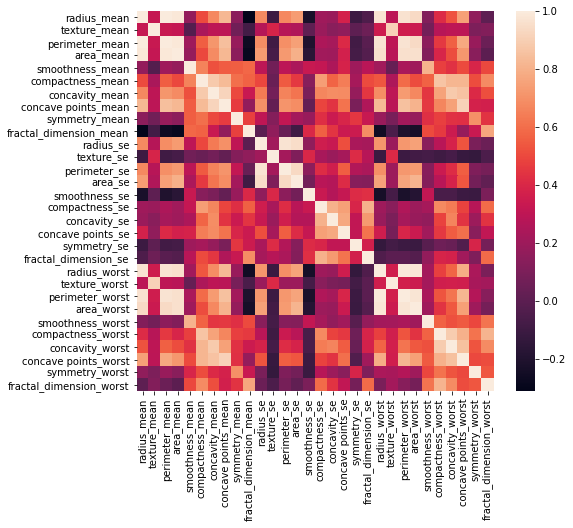

In [9]:
plt.figure(figsize=(8,7))
_=sns.heatmap(x.corr())

In [10]:
corr=x.corr()

In [11]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [12]:
# Selected column
cols_pass=x.columns[columns].to_list()
cols_dropped_corr=x.columns[~columns].to_list()

In [13]:
print('Number of selected cols: {}'.format(len(cols_pass)))
cols_pass

Number of selected cols: 20


['radius_mean',
 'texture_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [14]:
print('Number of removed cols: {}'.format(len(cols_dropped_corr)))
cols_dropped_corr

Number of removed cols: 10


['perimeter_mean',
 'area_mean',
 'concave points_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'concave points_worst']

In [15]:
corr_dict=corr.to_dict()

In [16]:
high_col={}
for col in corr.columns:
    one_col=corr_dict[col]
    high_col[col]=[y for y in one_col if one_col[y]>=0.9 and one_col[y]< 1]

In [17]:
# Drop keys with empty list (Not highly correlated with any other variable)
high_col={k: v for k, v in high_col.items() if v}

In [18]:
high_col

{'radius_mean': ['perimeter_mean',
  'area_mean',
  'radius_worst',
  'perimeter_worst',
  'area_worst'],
 'texture_mean': ['texture_worst'],
 'perimeter_mean': ['radius_mean',
  'area_mean',
  'radius_worst',
  'perimeter_worst',
  'area_worst'],
 'area_mean': ['radius_mean',
  'perimeter_mean',
  'radius_worst',
  'perimeter_worst',
  'area_worst'],
 'concavity_mean': ['concave points_mean'],
 'concave points_mean': ['concavity_mean', 'concave points_worst'],
 'radius_se': ['perimeter_se', 'area_se'],
 'perimeter_se': ['radius_se', 'area_se'],
 'area_se': ['radius_se', 'perimeter_se'],
 'radius_worst': ['radius_mean',
  'perimeter_mean',
  'area_mean',
  'perimeter_worst',
  'area_worst'],
 'texture_worst': ['texture_mean'],
 'perimeter_worst': ['radius_mean',
  'perimeter_mean',
  'area_mean',
  'radius_worst',
  'area_worst'],
 'area_worst': ['radius_mean',
  'perimeter_mean',
  'area_mean',
  'radius_worst',
  'perimeter_worst'],
 'concave points_worst': ['concave points_mean']}

By removing columns which are highly correlated (>=0.9, which is very high correlation usualy), we remain with 20 features

#### Tree based feature selection and random forest classification

In [19]:
x_new=x[cols_pass]

In [20]:
# split data train 80 % and test 20 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
def random_forest_fimportance(x_train,y_train):
    clf_rf_5 = RandomForestClassifier()      
    clr_rf_5 = clf_rf_5.fit(x_train,y_train)
    importances = clr_rf_5.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(x_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest

    plt.figure(1, figsize=(14, 7))
    plt.title("Feature importances")
    plt.bar(range(x_train.shape[1]), importances[indices])
    plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
    plt.xlim([-1, x_train.shape[1]])
    plt.show()
    
    return clf_rf_5

Feature ranking:
1. feature 22 (0.156425)
2. feature 23 (0.128026)
3. feature 27 (0.121384)
4. feature 7 (0.121312)
5. feature 20 (0.089879)
6. feature 6 (0.058854)
7. feature 3 (0.048348)
8. feature 26 (0.034047)
9. feature 13 (0.029527)
10. feature 2 (0.028704)
11. feature 0 (0.025939)
12. feature 21 (0.018890)
13. feature 28 (0.017807)
14. feature 1 (0.015529)
15. feature 25 (0.014148)
16. feature 24 (0.013267)
17. feature 5 (0.010074)
18. feature 16 (0.008136)
19. feature 10 (0.007263)
20. feature 4 (0.007112)
21. feature 11 (0.006501)
22. feature 17 (0.005790)
23. feature 12 (0.005077)
24. feature 9 (0.004512)
25. feature 19 (0.004265)
26. feature 18 (0.004151)
27. feature 29 (0.004098)
28. feature 15 (0.003973)
29. feature 14 (0.003548)
30. feature 8 (0.003414)


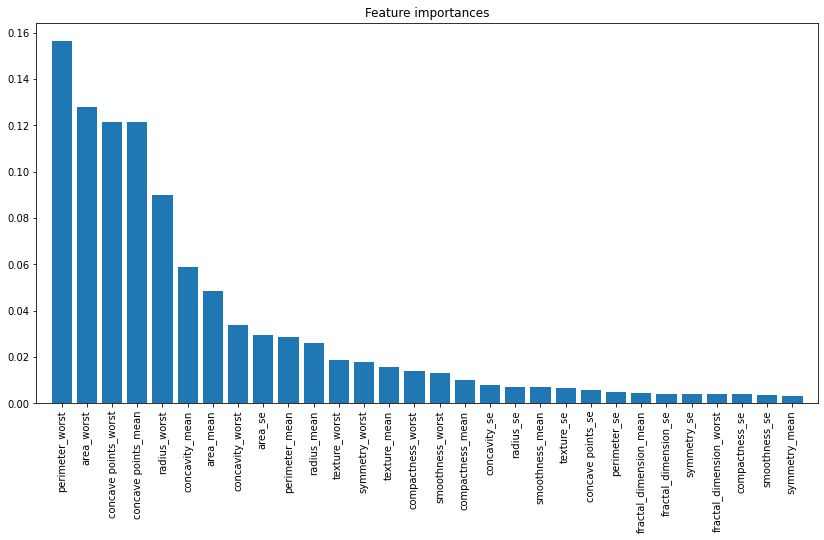

In [22]:
rf_model1=random_forest_fimportance(x_train,y_train)

Accuracy is:  0.9649122807017544


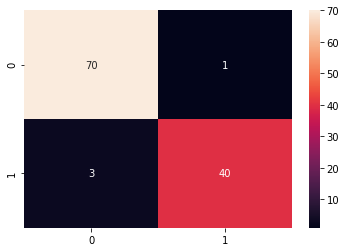

In [23]:
acc_score = accuracy_score(y_test,rf_model1.predict(x_test))
print('Accuracy is: ',acc_score)
confusion_mat = confusion_matrix(y_test,rf_model1.predict(x_test))
_=sns.heatmap(confusion_mat,annot=True,fmt="d")

In [24]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_new, y, test_size=0.2, random_state=423)

Feature ranking:
1. feature 0 (0.214319)
2. feature 17 (0.154183)
3. feature 4 (0.147065)
4. feature 7 (0.103061)
5. feature 16 (0.059354)
6. feature 3 (0.056366)
7. feature 1 (0.038933)
8. feature 15 (0.024774)
9. feature 12 (0.024114)
10. feature 11 (0.021322)
11. feature 6 (0.020743)
12. feature 18 (0.019534)
13. feature 9 (0.016647)
14. feature 10 (0.016625)
15. feature 19 (0.016270)
16. feature 2 (0.015998)
17. feature 13 (0.014944)
18. feature 14 (0.014650)
19. feature 5 (0.011568)
20. feature 8 (0.009530)


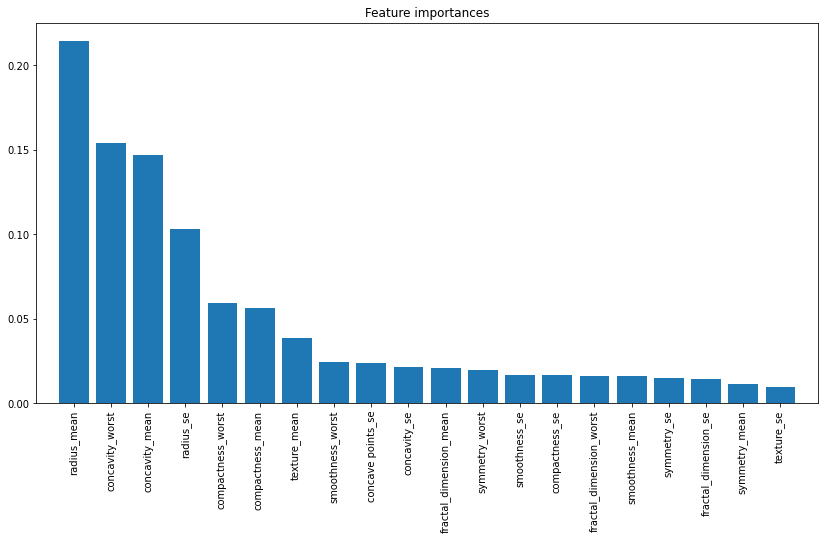

In [25]:
rf_model2=random_forest_fimportance(x_train1,y_train1)

Accuracy is: 0.9912280701754386


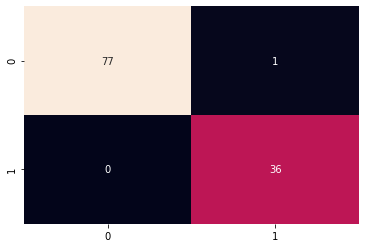

In [26]:
acc_score1 = accuracy_score(y_test1,rf_model2.predict(x_test1))
print('Accuracy is: {}'.format(acc_score1))
confusion_mat1 = confusion_matrix(y_test1,rf_model2.predict(x_test1))
_=sns.heatmap(confusion_mat1,annot=True,fmt="d",cbar=False)

By using confusion matrix accuracy score, we can see that the RF with 20 features actually has more accuracy that the model with 30 features

### Stepwise forward elimination

In [60]:
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included,model

In [54]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included,model

In [55]:
cols_pass_fwd,model_fwd=forward_regression(x,y,0.05,verbose=True)

Add  concave points_worst           with p-value 1.9691e-124
Add  radius_worst                   with p-value 9.9718e-24
Add  texture_worst                  with p-value 3.39287e-11
Add  area_worst                     with p-value 1.65889e-05
Add  smoothness_se                  with p-value 2.91155e-07
Add  symmetry_worst                 with p-value 3.43004e-05
Add  compactness_se                 with p-value 0.00672453
Add  radius_se                      with p-value 0.000726958
Add  fractal_dimension_worst        with p-value 0.00195804
Add  compactness_mean               with p-value 0.00456211
Add  concave points_mean            with p-value 0.00103855
Add  concavity_worst                with p-value 0.0399533
Add  concavity_se                   with p-value 0.010809
Add  area_se                        with p-value 0.0395764


In [56]:
cols_pass_fwd

['concave points_worst',
 'radius_worst',
 'texture_worst',
 'area_worst',
 'smoothness_se',
 'symmetry_worst',
 'compactness_se',
 'radius_se',
 'fractal_dimension_worst',
 'compactness_mean',
 'concave points_mean',
 'concavity_worst',
 'concavity_se',
 'area_se']

In [70]:
dropped,model_bwd=backward_regression(x,y,0.6,verbose=True)

Drop fractal_dimension_mean         with p-value 0.99524
Drop compactness_se                 with p-value 0.976352
Drop smoothness_mean                with p-value 0.967554
Drop symmetry_mean                  with p-value 0.883741
Drop texture_se                     with p-value 0.877632
Drop compactness_worst              with p-value 0.822968
Drop perimeter_worst                with p-value 0.716892
Drop concave points_worst           with p-value 0.610862
Drop area_se                        with p-value 0.64006


In [71]:
cols_dropped_bwd=list(x.columns.difference(dropped))

In [78]:
cols_dropped_bwd

['area_se',
 'compactness_se',
 'compactness_worst',
 'concave points_worst',
 'fractal_dimension_mean',
 'perimeter_worst',
 'smoothness_mean',
 'symmetry_mean',
 'texture_se']

In [73]:
set(cols_dropped_bwd)&set(cols_dropped_corr)

{'area_se', 'concave points_worst', 'perimeter_worst'}

In [74]:
set(cols_pass)&set(cols_pass_fwd)

{'compactness_mean',
 'compactness_se',
 'concavity_se',
 'concavity_worst',
 'fractal_dimension_worst',
 'radius_se',
 'smoothness_se',
 'symmetry_worst'}

Because with highly correlated variables, based on correlation method can pick any first variable
among two or three that are highly correlated, then I have used a simple rule by making sure
that variable that were removed by two methods (correlation& backward elimination) and those
variables that were selected by two methods (correlation & forward selection) are considered.
And then I can arbitrary select any one variable among highly correlated variables for those
that are not agreed on by two methods.

In [75]:
x.columns.difference(set(cols_pass)&set(cols_pass_fwd) | set(cols_dropped_bwd)&set(cols_dropped_corr))

Index(['area_mean', 'area_worst', 'compactness_worst', 'concave points_mean',
       'concave points_se', 'concavity_mean', 'fractal_dimension_mean',
       'fractal_dimension_se', 'perimeter_mean', 'perimeter_se', 'radius_mean',
       'radius_worst', 'smoothness_mean', 'smoothness_worst', 'symmetry_mean',
       'symmetry_se', 'texture_mean', 'texture_se', 'texture_worst'],
      dtype='object')

#### Selecting the optimal columns 
*'area_se'* can be represented by *'radius_se'* \

*'texture_worst'* can be represented *'texture_mean'*

*'compactness_worst', 'concave points_se','fractal_dimension_mean','fractal_dimension_se','smoothness_mean',
'smoothness_worst','symmetry_mean','symmetry_se','texture_se'* are not correlated(>=0.9) with any other variable so they will be selected\

*'concave points_worst','concave points_mean','concavity_mean'*  I will select *'concave points_mean'*\

*'perimeter_worst','radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'area_worst'* are highly correlated, so i select *'radius_mean'* and *'radius_worst'*

In [76]:
final_cols=['compactness_worst','compactness_mean','compactness_se','concavity_se','concavity_worst',
            'fractal_dimension_worst','radius_se','smoothness_se','symmetry_worst','concave points_mean',
            'smoothness_mean','smoothness_worst','symmetry_mean','fractal_dimension_mean','radius_mean',
            'radius_worst','symmetry_se','texture_se']

In [77]:
len(final_cols)

18